# Empirical mode decomposition

**Datasets** : CWRU bearing vibration data (Normal_0 vs IR007_0)


데이터 로드 성공: 10000개 샘플


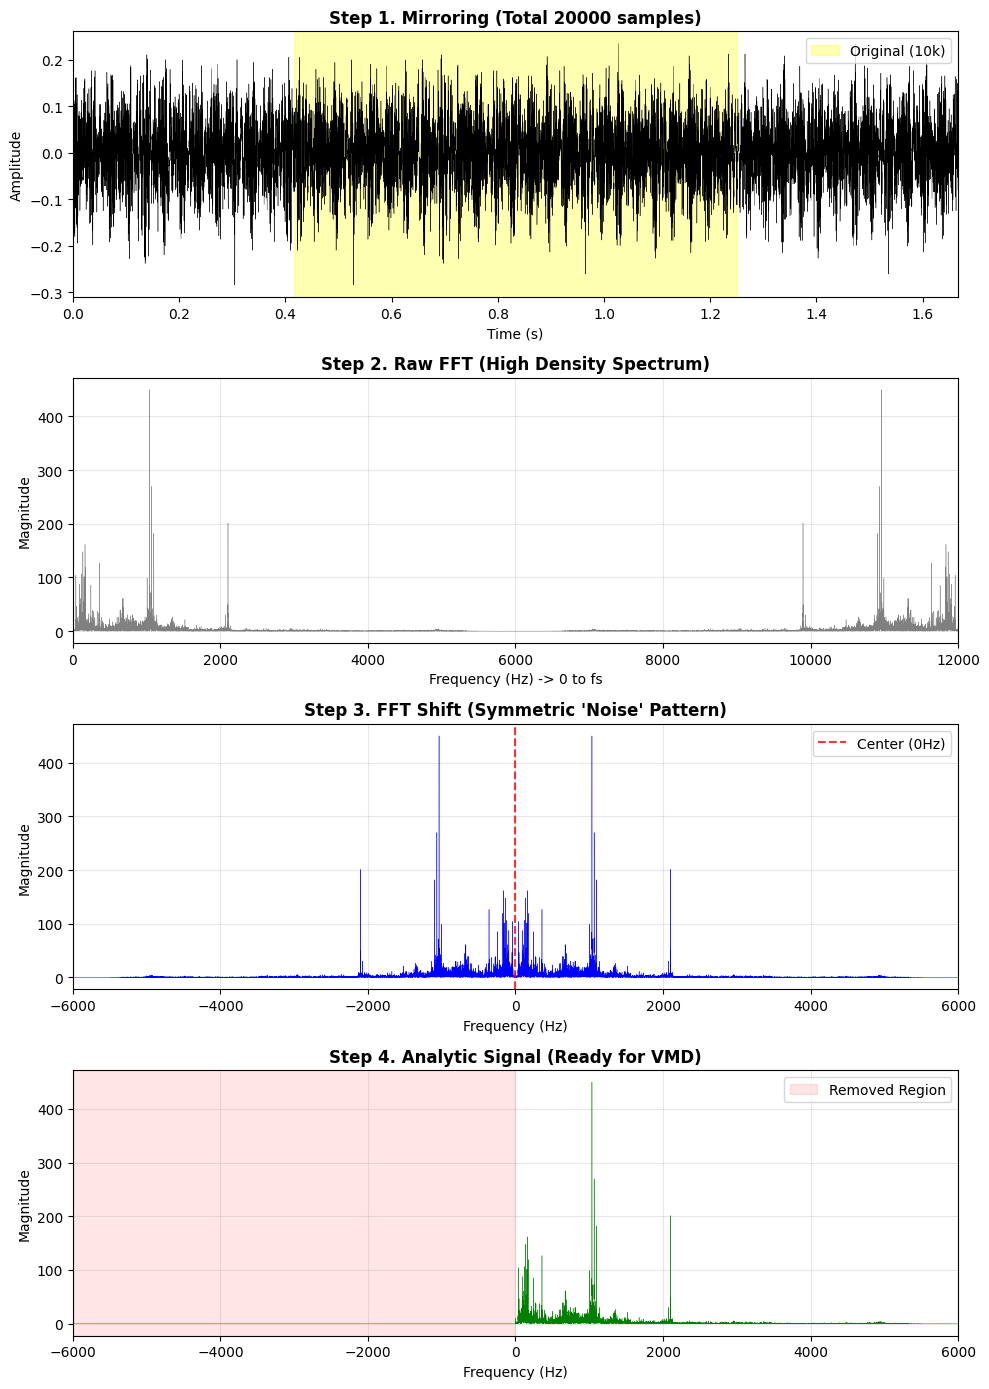

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# ==========================================
# 1. 설정
# ==========================================
CHUNK_SIZE = 10000       # [요청하신 크기] 10,000개
fs = 12000               # 샘플링 레이트
PATH_NORMAL = 'datasets/cwru/Normal_0.mat'

# ==========================================
# 2. 전처리 과정 함수 (Step 1~4)
# ==========================================
def VMD_Preprocessing_RealScale(signal, fs):
    # [Step 1] 미러링 (Mirroring)
    # 신호의 절반(T/2)만큼을 양옆에 거울처럼 붙여서 총 2T 길이로 만듦
    T = len(signal)
    if T % 2: signal = signal[:-1] # 짝수로 맞춤
    
    ltemp = len(signal) // 2
    # 왼쪽 확장 + 원본 + 오른쪽 확장
    fMirr = np.append(np.flip(signal[:ltemp], axis=0), signal)
    fMirr = np.append(fMirr, np.flip(signal[-ltemp:], axis=0))
    
    # 시간 축 (2배로 늘어남)
    t_axis_mirr = np.arange(len(fMirr)) / fs

    # [Step 2] FFT (Raw Output)
    # 결과: 0Hz가 양 끝에 찢어져 있는 형태
    f_hat_raw = np.fft.fft(fMirr)
    
    # 주파수 축 (0 ~ fs)
    freq_raw = np.linspace(0, fs, len(f_hat_raw))

    # [Step 3] FFT Shift (Centering)
    # 결과: 0Hz가 가운데로 오고, 좌우 대칭인 산맥 형태
    f_hat_shifted = np.fft.fftshift(f_hat_raw)
    
    # 주파수 축 (-fs/2 ~ +fs/2)
    N_total = len(fMirr)
    freq_shifted = np.linspace(-fs/2, fs/2, N_total)

    # [Step 4] Analytic Signal (Negative Removal)
    # 결과: 왼쪽(음수) 절반을 0으로 삭제
    f_hat_plus = np.copy(f_hat_shifted)
    f_hat_plus[:N_total // 2] = 0 

    return t_axis_mirr, fMirr, freq_raw, f_hat_raw, freq_shifted, f_hat_shifted, f_hat_plus

# ==========================================
# 3. 데이터 로드 및 실행
# ==========================================
try:
    mat = sio.loadmat(PATH_NORMAL)
    key = [k for k in mat.keys() if 'DE_time' in k][0]
    # [중요] 10,000개 로드
    raw_data = mat[key].flatten()[:CHUNK_SIZE]
    raw_data = raw_data - np.mean(raw_data)
    print(f"데이터 로드 성공: {len(raw_data)}개 샘플")

    # 함수 실행
    t_mirr, step1, f_raw, step2, f_shift, step3, step4 = VMD_Preprocessing_RealScale(raw_data, fs)

    # ==========================================
    # 4. 시각화
    # ==========================================
    fig, axes = plt.subplots(4, 1, figsize=(10, 14))

    # [Step 1] Mirroring
    # 데이터가 많으므로 선 굵기(linewidth)를 얇게 해서 뭉개짐 방지
    axes[0].plot(t_mirr, step1, 'k', linewidth=0.3)
    # 원본 구간 표시
    orig_start = t_mirr[len(raw_data)//2]
    orig_end = t_mirr[len(raw_data)//2 + len(raw_data)]
    axes[0].axvspan(orig_start, orig_end, color='yellow', alpha=0.3, label='Original (10k)')
    axes[0].set_title(f"Step 1. Mirroring (Total {len(step1)} samples)", fontweight='bold')
    axes[0].set_ylabel("Amplitude")
    axes[0].set_xlabel("Time (s)")
    axes[0].legend(loc='upper right')
    axes[0].set_xlim(t_mirr[0], t_mirr[-1])

    # [Step 2] Raw FFT
    axes[1].plot(f_raw, np.abs(step2), 'gray', linewidth=0.3)
    axes[1].set_title("Step 2. Raw FFT (High Density Spectrum)", fontweight='bold')
    axes[1].set_ylabel("Magnitude")
    axes[1].set_xlabel("Frequency (Hz) -> 0 to fs")
    axes[1].set_xlim(0, fs)
    axes[1].grid(True, alpha=0.3)

    # [Step 3] FFT Shift
    axes[2].plot(f_shift, np.abs(step3), 'b', linewidth=0.3)
    axes[2].axvline(0, color='r', linestyle='--', alpha=0.8, label='Center (0Hz)')
    axes[2].set_title("Step 3. FFT Shift (Symmetric 'Noise' Pattern)", fontweight='bold')
    axes[2].set_ylabel("Magnitude")
    axes[2].set_xlabel("Frequency (Hz)")
    axes[2].set_xlim(-fs/2, fs/2)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    # [Step 4] Analytic Signal
    axes[3].plot(f_shift, np.abs(step4), 'g', linewidth=0.3)
    axes[3].axvspan(-fs/2, 0, color='red', alpha=0.1, label='Removed Region')
    axes[3].set_title("Step 4. Analytic Signal (Ready for VMD)", fontweight='bold')
    axes[3].set_ylabel("Magnitude")
    axes[3].set_xlabel("Frequency (Hz)")
    axes[3].set_xlim(-fs/2, fs/2)
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"오류 발생: {e}")
    print("dataset 폴더에 Normal_0.mat 파일이 있는지 확인해주세요.")

>> 데이터 로드 완료: 10000 samples
>> DC Offset 제거 완료 (Mean: -0.00000)
>> VMD 분석 시작 (K=4)...
>> VMD 완료 (반복 횟수: 20)


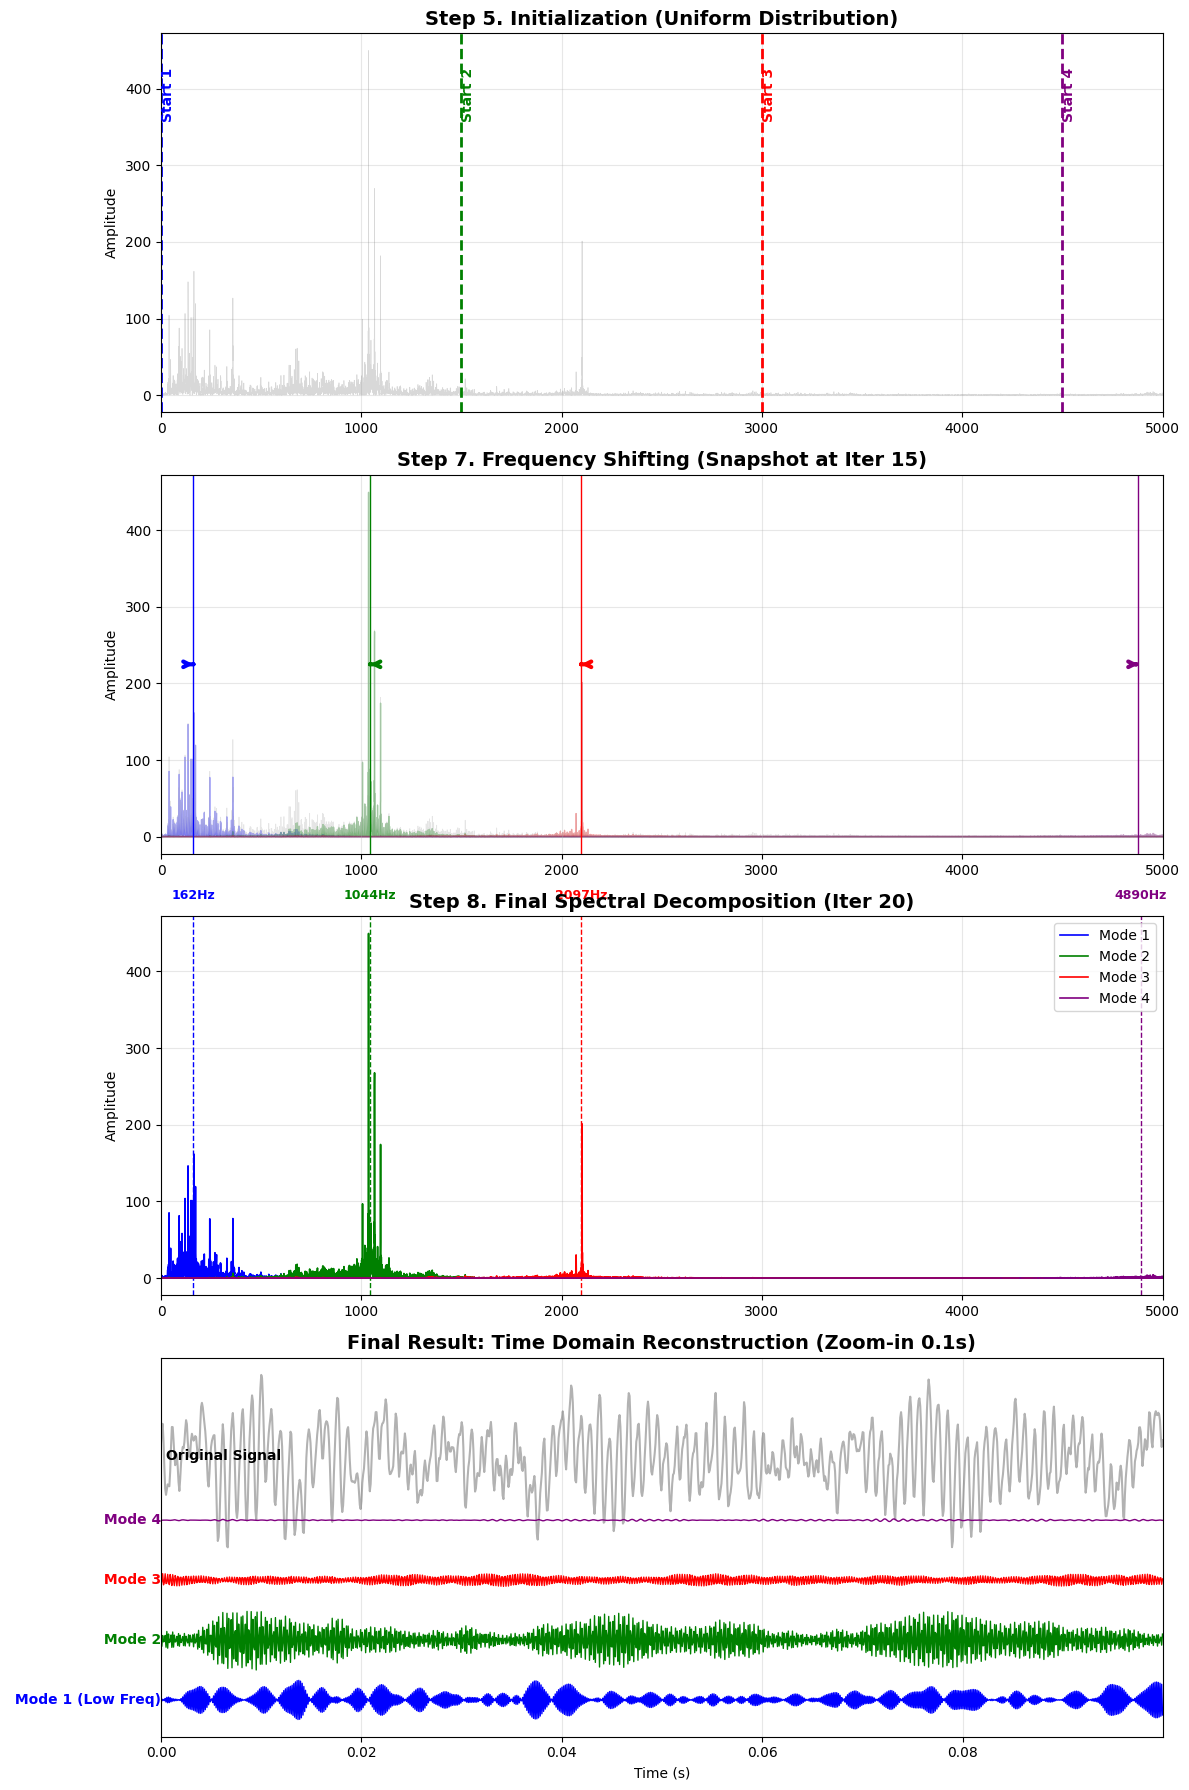

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# ==========================================
# 1. 설정 (Configuration)
# ==========================================
CHUNK_SIZE = 10000       # 분석할 데이터 길이 (약 0.83초)
fs = 12000               # 샘플링 레이트
PATH_NORMAL = 'datasets/cwru/Normal_0.mat'  # 파일 경로
K_MODES = 4              # [수정] 모드 개수를 4개로 설정 (결함 분리 최적화)
ALPHA = 2000             # 대역폭 제한 (클수록 좁은 대역폭)

# ==========================================
# 2. VMD 알고리즘 함수 (과정 스냅샷 포함)
# ==========================================
def VMD_Process_Complete(signal, fs, K=4, alpha=2000, tau=0, tol=1e-7):
    """
    VMD 알고리즘을 수행하고, 과정(Step 5, 7, 8)의 데이터를 스냅샷으로 저장하여 반환합니다.
    """
    # --- [전처리] ---
    # 1. 길이 짝수 맞춤
    if len(signal) % 2: signal = signal[:-1]
    
    # 2. 미러링 (Mirroring): 경계 효과 감소를 위해 신호 확장
    ltemp = len(signal) // 2
    fMirr = np.append(np.flip(signal[:ltemp], axis=0), signal)
    fMirr = np.append(fMirr, np.flip(signal[-ltemp:], axis=0))
    
    T = len(fMirr)
    freqs = np.arange(T) / T
    real_freqs = freqs * fs  # 실제 주파수축 (Hz)
    
    # 3. FFT 및 Analytic Signal 변환 (음수 주파수 제거)
    f_hat = np.fft.fft(fMirr)
    f_hat_plus = f_hat.copy()
    f_hat_plus[T // 2:] = 0

    # --- [VMD 초기화] ---
    Niter = 200
    Alpha = alpha * np.ones(K)
    omega_plus = np.zeros([Niter, K])
    
    # 중심 주파수 초기화 (0 ~ 0.5 사이 균등 배분)
    for i in range(K):
        omega_plus[0, i] = (0.5 / K) * i 
        
    u_hat_plus = np.zeros([Niter, T, K], dtype=complex)
    lambda_hat = np.zeros([Niter, T], dtype=complex)
    
    # 스냅샷 저장소
    snapshots = {}
    snapshots['step5_init'] = omega_plus[0, :].copy()

    # --- [ADMM 최적화 루프] ---
    uDiff = tol + np.spacing(1)
    n = 0
    sum_uk = 0 
    
    while (uDiff > tol and n < Niter - 1):
        # u_k 업데이트 (Wiener Filter 구조)
        k = 0
        sum_uk = u_hat_plus[n, :, K - 1] + sum_uk - u_hat_plus[n, :, 0]
        u_hat_plus[n + 1, :, k] = (f_hat_plus - sum_uk - lambda_hat[n, :] / 2) / (1. + Alpha[k] * (freqs - omega_plus[n, k])**2)
        
        # omega_k 업데이트 (Center of Gravity)
        omega_plus[n + 1, k] = np.dot(freqs[0:T//2], (np.abs(u_hat_plus[n + 1, 0:T//2, k])**2)) / np.sum(np.abs(u_hat_plus[n + 1, 0:T//2, k])**2)

        for k in np.arange(1, K):
            sum_uk = u_hat_plus[n + 1, :, k - 1] + sum_uk - u_hat_plus[n, :, k]
            u_hat_plus[n + 1, :, k] = (f_hat_plus - sum_uk - lambda_hat[n, :] / 2) / (1 + Alpha[k] * (freqs - omega_plus[n, k])**2)
            omega_plus[n + 1, k] = np.dot(freqs[0:T//2], (np.abs(u_hat_plus[n + 1, 0:T//2, k])**2)) / np.sum(np.abs(u_hat_plus[n + 1, 0:T//2, k])**2)

        # lambda 업데이트 (Dual Ascent)
        lambda_hat[n + 1, :] = lambda_hat[n, :] + tau * (np.sum(u_hat_plus[n + 1, :, :], axis=1) - f_hat_plus)
        n = n + 1
        
        # 수렴 확인
        uDiff = np.spacing(1)
        for i in range(K):
            uDiff = uDiff + (1 / T) * np.dot((u_hat_plus[n, :, i] - u_hat_plus[n - 1, :, i]), np.conj((u_hat_plus[n, :, i] - u_hat_plus[n - 1, :, i])))
        uDiff = np.abs(uDiff)
        
        # [Step 7] 중간 과정 스냅샷 (이동 중인 상태)
        if n == 15: 
            snapshots['step7_move_prev'] = omega_plus[n-1, :].copy()
            snapshots['step7_move_curr'] = omega_plus[n, :].copy()
            snapshots['step7_u'] = u_hat_plus[n, :, :].copy()

    # [Step 8] 최종 결과 스냅샷
    snapshots['step8_final_u'] = u_hat_plus[n, :, :].copy()
    snapshots['step8_final_w'] = omega_plus[n, :].copy()
    
    return f_hat_plus, real_freqs, snapshots, n

# ==========================================
# 3. 실행 및 데이터 로드
# ==========================================
try:
    # 1. 데이터 로드
    mat = sio.loadmat(PATH_NORMAL)
    key = [k for k in mat.keys() if 'DE_time' in k][0]
    
    raw_data = mat[key].flatten()[:CHUNK_SIZE].astype(np.float64)
    
    # [중요] DC Offset 제거 (0점 조절)
    raw_data = raw_data - np.mean(raw_data)
    
    print(f">> 데이터 로드 완료: {len(raw_data)} samples")
    print(f">> DC Offset 제거 완료 (Mean: {np.mean(raw_data):.5f})")
    
    # 2. VMD 실행 (K=4)
    print(f">> VMD 분석 시작 (K={K_MODES})...")
    f_spectrum, freq_axis, snaps, final_iter = VMD_Process_Complete(raw_data, fs, K=K_MODES, alpha=ALPHA)
    print(f">> VMD 완료 (반복 횟수: {final_iter})")

    # ==========================================
    # 4. 시각화 (Visualization)
    # ==========================================
    fig, axes = plt.subplots(4, 1, figsize=(12, 18))
    colors = ['blue', 'green', 'red', 'purple'] # 모드별 색상 (K=4)
    max_freq_view = 5000  # 주파수 뷰 제한 (5kHz)

    # --- [Step 5] 초기화 (Initialization) ---
    ax1 = axes[0]
    # 전체 스펙트럼 (배경)
    ax1.plot(freq_axis[:len(freq_axis)//2], np.abs(f_spectrum[:len(f_spectrum)//2]), color='gray', alpha=0.3, linewidth=0.5)
    
    init_omegas = snaps['step5_init'] * fs
    for k in range(K_MODES):
        ax1.axvline(init_omegas[k], color=colors[k], linestyle='--', linewidth=2)
        ax1.text(init_omegas[k], np.max(np.abs(f_spectrum))*0.8, f'Start {k+1}', color=colors[k], rotation=90, fontweight='bold')
    
    ax1.set_title(f"Step 5. Initialization (Uniform Distribution)", fontsize=14, fontweight='bold')
    ax1.set_xlim(0, max_freq_view)
    ax1.set_ylabel("Amplitude")
    ax1.grid(True, alpha=0.3)

    # --- [Step 7] 이동 과정 (Frequency Shifting) ---
    ax2 = axes[1]
    ax2.plot(freq_axis[:len(freq_axis)//2], np.abs(f_spectrum[:len(f_spectrum)//2]), color='gray', alpha=0.2, linewidth=0.5)
    
    prev_w = snaps['step7_move_prev'] * fs
    curr_w = snaps['step7_move_curr'] * fs
    current_u = snaps['step7_u']

    for k in range(K_MODES):
        # 현재 모드 형상
        ax2.fill_between(freq_axis[:len(freq_axis)//2], np.abs(current_u[:len(current_u)//2, k]), color=colors[k], alpha=0.3)
        # 화살표 표시
        ax2.annotate("", xy=(curr_w[k], np.max(np.abs(f_spectrum))*0.5), xytext=(prev_w[k], np.max(np.abs(f_spectrum))*0.5),
                      arrowprops=dict(arrowstyle="->", color=colors[k], lw=3))
        ax2.axvline(curr_w[k], color=colors[k], linestyle='-', linewidth=1)

    ax2.set_title(f"Step 7. Frequency Shifting (Snapshot at Iter 15)", fontsize=14, fontweight='bold')
    ax2.set_xlim(0, max_freq_view)
    ax2.set_ylabel("Amplitude")
    ax2.grid(True, alpha=0.3)

    # --- [Step 8] 최종 수렴 (Final Convergence) ---
    ax3 = axes[2]
    final_u = snaps['step8_final_u']
    final_w = snaps['step8_final_w'] * fs

    for k in range(K_MODES):
        ax3.plot(freq_axis[:len(freq_axis)//2], np.abs(final_u[:len(final_u)//2, k]), color=colors[k], linewidth=1.2, label=f'Mode {k+1}')
        ax3.axvline(final_w[k], color=colors[k], linestyle='--', linewidth=1)
        ax3.text(final_w[k], np.max(np.abs(final_u))*1.1, f"{final_w[k]:.0f}Hz", color=colors[k], ha='center', fontweight='bold', fontsize=9)

    ax3.set_title(f"Step 8. Final Spectral Decomposition (Iter {final_iter})", fontsize=14, fontweight='bold')
    ax3.set_xlim(0, max_freq_view)
    ax3.set_ylabel("Amplitude")
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)

    # --- [Final Result] 시간 영역 복원 (Time Domain Reconstruction) ---
    ax4 = axes[3]
    
    # IFFT 수행 (주파수 -> 시간)
    T_full = final_u.shape[0]
    modes_time = np.zeros((T_full, K_MODES))
    for k in range(K_MODES):
        modes_time[:, k] = np.real(np.fft.ifft(np.fft.ifftshift(final_u[:, k])))

    # 미러링 제거 (유효 구간 추출)
    start_idx = T_full // 4
    end_idx = 3 * T_full // 4
    valid_time_axis = np.arange(end_idx - start_idx) / fs
    valid_modes = modes_time[start_idx:end_idx, :]
    
    # 줌인 설정 (0.1초 구간만 확대)
    zoom_samples = int(0.1 * fs) # 0.1초 * 12000Hz = 1200 샘플
    zoom_time = valid_time_axis[:zoom_samples]
    zoom_data = valid_modes[:zoom_samples, :]
    
    # 그래프 그리기 (Offset 주어 겹치지 않게)
    offset_val = np.max(np.abs(zoom_data)) * 2.0
    
    # 원본 신호 (배경)
    ax4.plot(zoom_time, raw_data[:zoom_samples] + (K_MODES * offset_val), 'k', alpha=0.3, label='Original')
    ax4.text(zoom_time[0], K_MODES * offset_val, " Original Signal", color='black', fontweight='bold', ha='left')

    for k in range(K_MODES):
        # 각 모드 그리기
        ax4.plot(zoom_time, zoom_data[:, k] + (k * offset_val), color=colors[k], linewidth=1.0)
        ax4.text(zoom_time[0], k * offset_val, f" Mode {k+1} (Low Freq)" if k==0 else f" Mode {k+1}", 
                 color=colors[k], fontweight='bold', ha='right', va='center')

    ax4.set_title("Final Result: Time Domain Reconstruction (Zoom-in 0.1s)", fontsize=14, fontweight='bold')
    ax4.set_xlabel("Time (s)")
    ax4.set_yticks([]) # Y축 눈금 제거 (상대적 크기만 중요)
    ax4.set_xlim(zoom_time[0], zoom_time[-1])
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\n[오류 발생] {e}")
    print("dataset 폴더에 'Normal_0.mat' 파일이 있는지, 경로가 정확한지 확인해주세요.")

d:\Projects\signal-feature-learning\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Projects\signal-feature-learning\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51012 (\N{HANGUL SYLLABLE EUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Projects\signal-feature-learning\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Projects\signal-feature-learning\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Projects\signal-feature-learning\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54616 (\N{HA

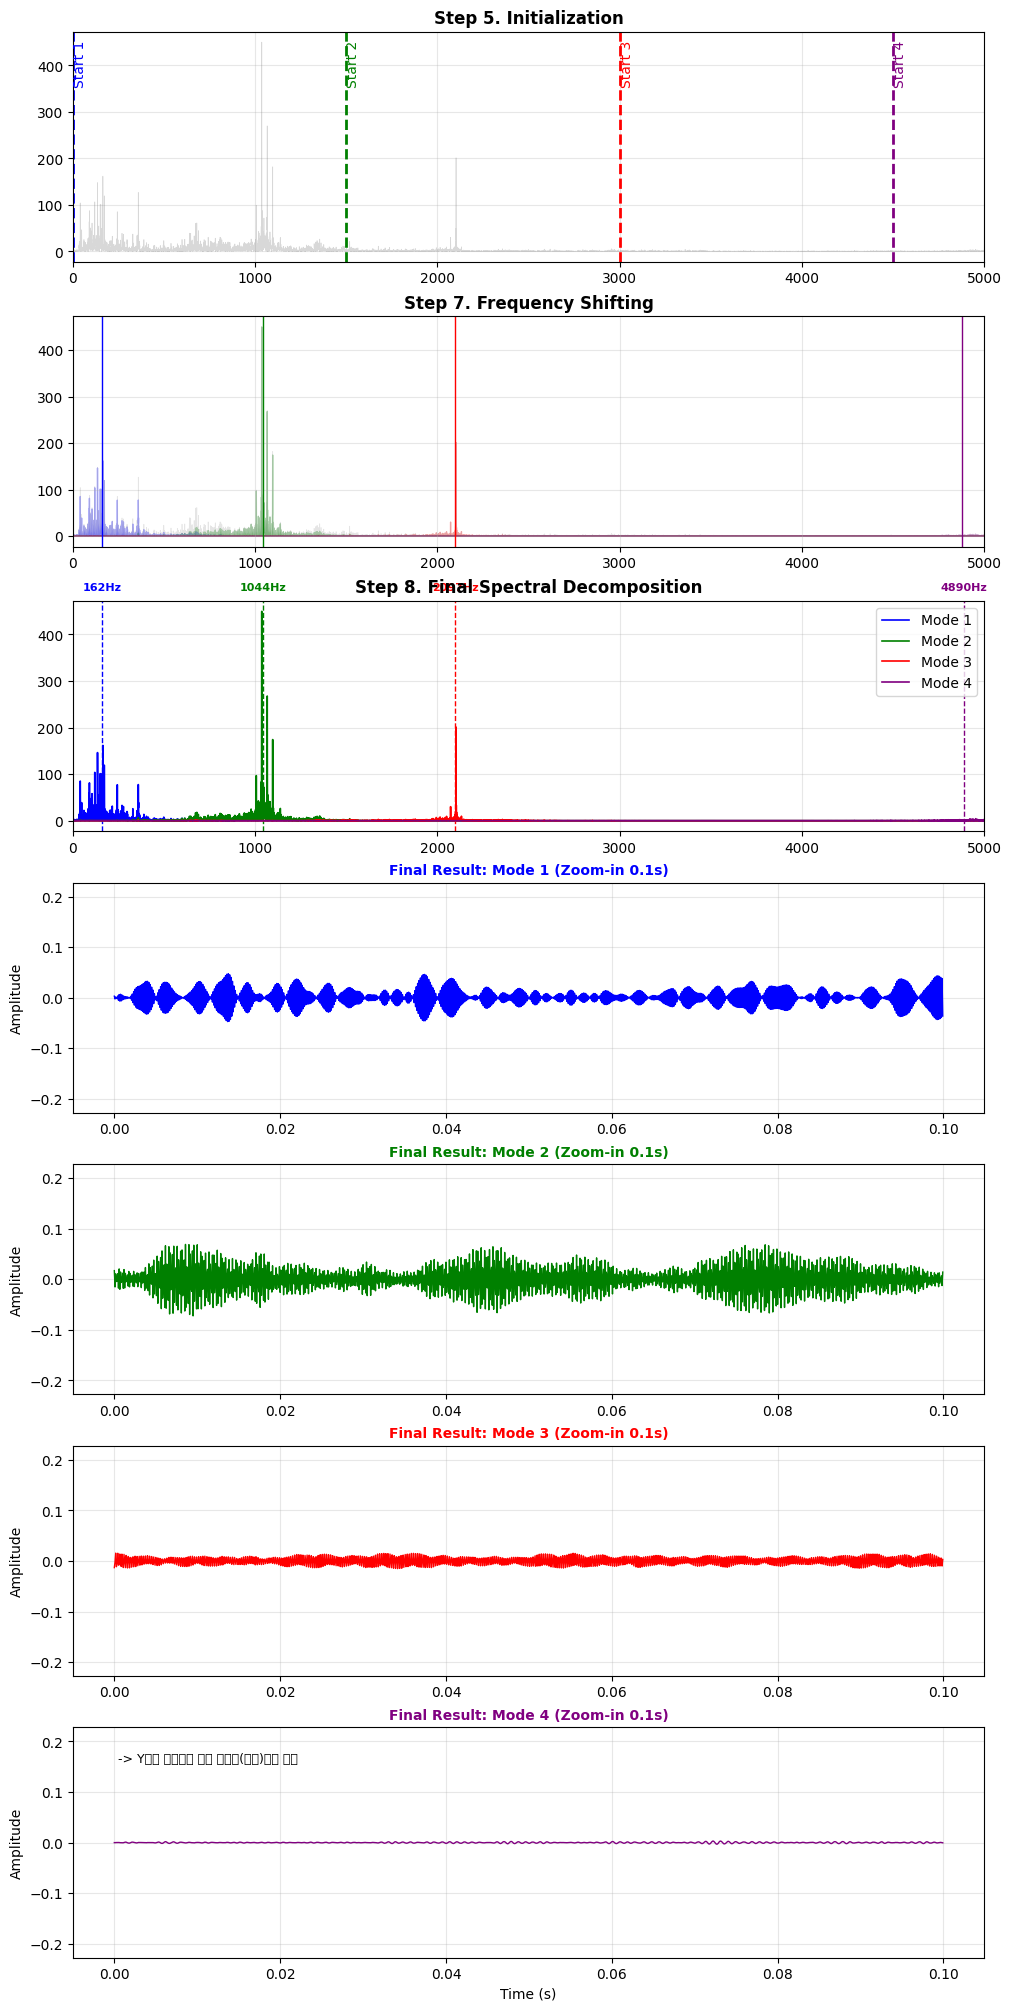

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# ==========================================
# 1. 설정 (기존과 동일)
# ==========================================
CHUNK_SIZE = 10000
fs = 12000
PATH_NORMAL = 'datasets/cwru/Normal_0.mat'
K_MODES = 4
ALPHA = 2000

# ==========================================
# 2. VMD 알고리즘 함수 (기존과 동일)
# ==========================================
def VMD_Process_Complete(signal, fs, K=4, alpha=2000, tau=0, tol=1e-7):
    # 전처리
    if len(signal) % 2: signal = signal[:-1]
    ltemp = len(signal) // 2
    fMirr = np.append(np.flip(signal[:ltemp], axis=0), signal)
    fMirr = np.append(fMirr, np.flip(signal[-ltemp:], axis=0))
    T = len(fMirr)
    freqs = np.arange(T) / T
    real_freqs = freqs * fs
    f_hat = np.fft.fft(fMirr)
    f_hat_plus = f_hat.copy()
    f_hat_plus[T // 2:] = 0

    # VMD 초기화
    Niter = 200
    Alpha = alpha * np.ones(K)
    omega_plus = np.zeros([Niter, K])
    for i in range(K):
        omega_plus[0, i] = (0.5 / K) * i
    u_hat_plus = np.zeros([Niter, T, K], dtype=complex)
    lambda_hat = np.zeros([Niter, T], dtype=complex)
    snapshots = {}
    snapshots['step5_init'] = omega_plus[0, :].copy()

    # ADMM 루프
    uDiff = tol + np.spacing(1)
    n = 0
    sum_uk = 0
    while (uDiff > tol and n < Niter - 1):
        k = 0
        sum_uk = u_hat_plus[n, :, K - 1] + sum_uk - u_hat_plus[n, :, 0]
        u_hat_plus[n + 1, :, k] = (f_hat_plus - sum_uk - lambda_hat[n, :] / 2) / (1. + Alpha[k] * (freqs - omega_plus[n, k])**2)
        omega_plus[n + 1, k] = np.dot(freqs[0:T//2], (np.abs(u_hat_plus[n + 1, 0:T//2, k])**2)) / np.sum(np.abs(u_hat_plus[n + 1, 0:T//2, k])**2)

        for k in np.arange(1, K):
            sum_uk = u_hat_plus[n + 1, :, k - 1] + sum_uk - u_hat_plus[n, :, k]
            u_hat_plus[n + 1, :, k] = (f_hat_plus - sum_uk - lambda_hat[n, :] / 2) / (1 + Alpha[k] * (freqs - omega_plus[n, k])**2)
            omega_plus[n + 1, k] = np.dot(freqs[0:T//2], (np.abs(u_hat_plus[n + 1, 0:T//2, k])**2)) / np.sum(np.abs(u_hat_plus[n + 1, 0:T//2, k])**2)

        lambda_hat[n + 1, :] = lambda_hat[n, :] + tau * (np.sum(u_hat_plus[n + 1, :, :], axis=1) - f_hat_plus)
        n = n + 1
        
        uDiff = np.spacing(1)
        for i in range(K):
            uDiff = uDiff + (1 / T) * np.dot((u_hat_plus[n, :, i] - u_hat_plus[n - 1, :, i]), np.conj((u_hat_plus[n, :, i] - u_hat_plus[n - 1, :, i])))
        uDiff = np.abs(uDiff)

        if n == 15:
            snapshots['step7_move_prev'] = omega_plus[n-1, :].copy()
            snapshots['step7_move_curr'] = omega_plus[n, :].copy()
            snapshots['step7_u'] = u_hat_plus[n, :, :].copy()

    snapshots['step8_final_u'] = u_hat_plus[n, :, :].copy()
    snapshots['step8_final_w'] = omega_plus[n, :].copy()
    return f_hat_plus, real_freqs, snapshots, n

# ==========================================
# 3. 실행 및 시각화 (수정됨)
# ==========================================
try:
    # 데이터 로드
    mat = sio.loadmat(PATH_NORMAL)
    key = [k for k in mat.keys() if 'DE_time' in k][0]
    raw_data = mat[key].flatten()[:CHUNK_SIZE].astype(np.float64)
    raw_data = raw_data - np.mean(raw_data) # DC 제거

    # VMD 실행
    f_spectrum, freq_axis, snaps, final_iter = VMD_Process_Complete(raw_data, fs, K=K_MODES, alpha=ALPHA)

    # IFFT 수행 (시간 영역 복원 데이터 준비)
    final_u = snaps['step8_final_u']
    T_full = final_u.shape[0]
    modes_time = np.zeros((T_full, K_MODES))
    for k in range(K_MODES):
        modes_time[:, k] = np.real(np.fft.ifft(np.fft.ifftshift(final_u[:, k])))
    
    # 미러링 제거 및 줌인 데이터 준비
    start_idx = T_full // 4
    end_idx = 3 * T_full // 4
    valid_modes = modes_time[start_idx:end_idx, :]
    
    # 0.1초 줌인
    zoom_samples = int(0.1 * fs)
    zoom_time = np.arange(zoom_samples) / fs
    zoom_data = valid_modes[:zoom_samples, :]
    
    # --- [시각화 수정] ---
    # 총 7개 행: Step 5, 7, 8 (각 1행) + Mode 1, 2, 3, 4 (각 1행)
    fig, axes = plt.subplots(7, 1, figsize=(10, 20), constrained_layout=True)
    colors = ['blue', 'green', 'red', 'purple']
    max_freq_view = 5000

    # 1. Step 5
    ax1 = axes[0]
    ax1.plot(freq_axis[:len(freq_axis)//2], np.abs(f_spectrum[:len(f_spectrum)//2]), color='gray', alpha=0.3, linewidth=0.5)
    init_omegas = snaps['step5_init'] * fs
    for k in range(K_MODES):
        ax1.axvline(init_omegas[k], color=colors[k], linestyle='--', linewidth=2)
        ax1.text(init_omegas[k], np.max(np.abs(f_spectrum))*0.8, f'Start {k+1}', color=colors[k], rotation=90)
    ax1.set_title("Step 5. Initialization", fontweight='bold')
    ax1.set_xlim(0, max_freq_view); ax1.grid(True, alpha=0.3)

    # 2. Step 7
    ax2 = axes[1]
    ax2.plot(freq_axis[:len(freq_axis)//2], np.abs(f_spectrum[:len(f_spectrum)//2]), color='gray', alpha=0.2, linewidth=0.5)
    current_u = snaps['step7_u']
    curr_w = snaps['step7_move_curr'] * fs
    for k in range(K_MODES):
        ax2.fill_between(freq_axis[:len(freq_axis)//2], np.abs(current_u[:len(current_u)//2, k]), color=colors[k], alpha=0.3)
        ax2.axvline(curr_w[k], color=colors[k], linestyle='-', linewidth=1)
    ax2.set_title("Step 7. Frequency Shifting", fontweight='bold')
    ax2.set_xlim(0, max_freq_view); ax2.grid(True, alpha=0.3)

    # 3. Step 8
    ax3 = axes[2]
    final_w = snaps['step8_final_w'] * fs
    for k in range(K_MODES):
        ax3.plot(freq_axis[:len(freq_axis)//2], np.abs(final_u[:len(final_u)//2, k]), color=colors[k], linewidth=1.2, label=f'Mode {k+1}')
        ax3.axvline(final_w[k], color=colors[k], linestyle='--', linewidth=1)
        ax3.text(final_w[k], np.max(np.abs(final_u))*1.1, f"{final_w[k]:.0f}Hz", color=colors[k], ha='center', fontweight='bold', fontsize=8)
    ax3.set_title("Step 8. Final Spectral Decomposition", fontweight='bold')
    ax3.set_xlim(0, max_freq_view); ax3.legend(loc='upper right'); ax3.grid(True, alpha=0.3)

    # 4. Final Result (Mode 1~4 분리 및 Y축 통일)
    # Y축 범위 고정값 설정 (원본 신호의 최대 진폭 기준)
    y_limit = np.max(np.abs(raw_data)) * 0.8  # 약 0.2 정도 예상
    
    for k in range(K_MODES):
        ax = axes[3 + k]
        ax.plot(zoom_time, zoom_data[:, k], color=colors[k], linewidth=1.0)
        ax.set_title(f"Final Result: Mode {k+1} (Zoom-in 0.1s)", fontsize=10, fontweight='bold', color=colors[k])
        ax.set_ylabel("Amplitude")
        ax.grid(True, alpha=0.3)
        
        # [핵심] Y축 범위를 모든 모드에 대해 동일하게 고정!
        ax.set_ylim(-y_limit, y_limit)
        
        # Mode 4에 텍스트 추가 (노이즈임을 강조)
        if k == 3:
            ax.text(zoom_time[0], y_limit*0.7, " -> Y축을 고정하니 거의 일직선(잡음)으로 보임", color='black', fontsize=9)

    axes[-1].set_xlabel("Time (s)")
    plt.show()

except Exception as e:
    print(e)